In [1]:
# imports
import torch
import json
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import torch.nn.functional as F

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

# figure aesthetics
# plt.style.use(['dark_background','seaborn-notebook'])  # for dark themes
plt.style.use(["../utils/dark.mplstyle","../utils/notebook.mplstyle"])
# plt.style.use(['seaborn-notebook'])

In [3]:
root = Path('..')

# custom libraries
import sys, os
sys.path.append(os.path.abspath('../'))
# print(f"{sys.executable = }")

from utils import spaths, dmaps
import sf_nets.models as models
import sf_nets.datasets as datasets
from utils.mpl_utils import coord_grid

In [4]:
# datasets directory
ds_path = root / 'data'

In [5]:
print(f"Available datasets : {[ds.stem for ds in ds_path.iterdir() if ds.is_dir()]}")

Available datasets : ['Sin2', 'Quad10', 'Cresc2', 'Quad4', 'Parab3', 'RQP4', 'LogSin2']


# Choose dataset

In [6]:
name_ds = 'Parab3'

In [7]:
data_path = root / 'data' / name_ds
model_path = root / 'results' / 'models' / name_ds.lower()

In [8]:
dataset = getattr(datasets, name_ds)
train_ds = dataset(root / 'data')
test_ds = dataset(root / 'data', train=False)
print(f"Size of training sample: {len(train_ds)}")
print(f"Size of testing sample: {len(test_ds)}")

Size of training sample: 2978
Size of testing sample: 1467


# Trained models

In [15]:
model_types = ['mah']

In [16]:
series_list = []
for file in os.listdir(model_path):
    fpath = Path(file)
    if fpath.suffix == '.pt' and any(mt in fpath.stem for mt in model_types):
        model_data = torch.load(model_path / fpath.name)
        par_dict = {
            key:val
            for key, val in model_data['info']['config'].items()
            if key in {'max_epochs'}
        }
#         par_dict['layers (i,l,[h])'] = model_data['state']['best_model_dict'].keys()
#         par_dict['train_size'] = model_data['info']['config']['loader']['train_size']
#         par_dict['valid_size'] = model_data['info']['config']['loader']['valid_size']
        par_dict['features'] = model_data['info'].get('features', [])
        pruning = model_data['info']['config'].get('pruning')
#         par_dict['sparsity'] = model_data['best']['sparsity'] if pruning else 0.0
        best_epoch_idx = model_data['best']['epoch']-1
        par_dict['best_epoch'] = best_epoch_idx
        par_dict['valid_loss'] = model_data['history']['valid_losses'][best_epoch_idx]
        par_dict['model_id'] = fpath.stem
        series_list.append(par_dict)
models_df = pd.DataFrame(series_list)
# models_df.set_index('model_id').sort_values(by='model_id')
(
models_df.set_index('model_id')
         .sort_values(by='model_id')
         .style.format({
             'sparsity': '{0:.0%}',
             'valid_loss': '{:.2}',
             'features': lambda x: "{:}".format(list(x)),  # TODO: format with dashes
             'burst_dt': '{:.0e}',
             'burst_size': '{:.0e}'
         })
         .set_properties(**{'font-size': '12pt',})
)

,max_epochs,features,best_epoch,valid_loss
model_id,,,,
mahl1_elu_1,1000,"[3, 4, 4, 2, 4, 4, 3]",939,0.0091
mahl1_elu_1_r1,1000,"[3, 4, 4, 2, 4, 4, 3]",588,0.0088
mahl1_elu_1a,1000,"[3, 4, 4, 2, 4, 4, 3]",974,0.0099


## Loss

In [36]:
model_id = 'mse_elu_0'

In [37]:
model_data = torch.load(model_path / f'{model_id}.pt')
print(f'{model_data.keys() = }')

model_data.keys() = dict_keys(['id', 'info', 'best', 'history'])


In [38]:
train_losses = model_data['history']['train_losses']
valid_losses = model_data['history']['valid_losses']
checkpoints = model_data['history']['checkpoints']
epochs = range(1, model_data['info']['config']['max_epochs']+1)
best_epoch = model_data['best']['epoch']

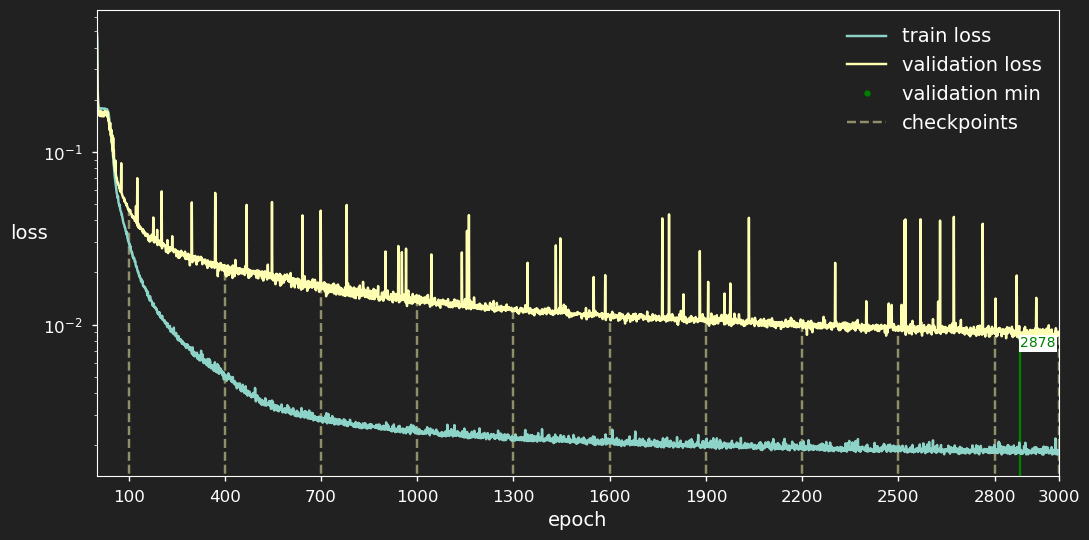

In [39]:
fig, ax = plt.subplots(figsize=(11,5.5))

ax.plot(epochs, train_losses, label="train loss")
loss_line, = ax.plot(epochs, valid_losses, label="validation loss")
loss_color = loss_line.get_color()

# regular checkpoints
check_ids = [check_id for check_id, check_type in checkpoints if check_type != 'best']
check_loss = [valid_losses[idx-1] for idx in check_ids]
plt.vlines(x=check_ids, ymin=0, ymax=check_loss, ls='--', color=loss_color, alpha=0.5, label='checkpoints')

# smallest validation loss / "best" model
smallest_loss = valid_losses[best_epoch-1]
plt.vlines(x=best_epoch, ymin=0, ymax=smallest_loss, color='g')
ax.plot(best_epoch, smallest_loss, 'o', color='g', label='validation min', markersize=3)

ax.text(best_epoch+2, .9*smallest_loss, f'{best_epoch}', rotation=0, color='g', bbox={'fc': 'w', 'ec':'None', 'boxstyle':'Square, pad=0.1'})

ax.set_xlim([epochs[0], epochs[-1]+1])
# ax.set_ylim([0.0, train_losses[1]])
ax.set_xticks(check_ids)
ax.set_xlabel("epoch")
ax.set_ylabel("loss", rotation=0, labelpad=10)
ax.set_yscale('log')
ax.legend()

fig.tight_layout()
# fig.savefig(root / f"results/figs/{model_id}_loss.pdf", dpi=300)
plt.show(fig)
plt.close(fig)

## Load Model

In [40]:
model = getattr(models, model_data['info']['architecture'])(**model_data['info']['arguments'])
model

MahalanobisAutoencoder(
  (encoder): Sequential(
    (layer1): Linear(in_features=2, out_features=4, bias=True)
    (activation1): ELU(alpha=1.0)
    (layer2): Linear(in_features=4, out_features=4, bias=True)
    (activation2): ELU(alpha=1.0)
    (layer3): Linear(in_features=4, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (layer1): Linear(in_features=1, out_features=4, bias=True)
    (activation1): ELU(alpha=1.0)
    (layer2): Linear(in_features=4, out_features=4, bias=True)
    (activation2): ELU(alpha=1.0)
    (layer3): Linear(in_features=4, out_features=2, bias=True)
  )
  (mah_loss): MahalanobisLoss()
  (proj_loss): MSELoss()
)

In [41]:
def remove_mask(model_dict):
    mask_state_dict = dict(filter(lambda elem: elem[0].endswith('_mask'), model_dict.items()))
    orig_state_dict = dict(filter(lambda elem: elem[0].endswith('_orig'), model_dict.items()))
    rest = dict(filter(lambda elem: elem[0].endswith(('weight', 'bias')), model_dict.items()))
    state_dict = {
        key.replace('_orig',''): val_orig * val_mask
        for (key, val_orig), val_mask in zip(orig_state_dict.items(), mask_state_dict.values())
    }
    return {**state_dict, **rest}

In [42]:
check_epoch = 'best'

In [43]:
if check_epoch == 'best':
    state_dict = remove_mask(model_data['best']['model_dict'])
#     state_dict = model_data['best']['model_dict']
    check_epoch = best_epoch
else:
    check_dict = torch.load(model_path / f'{model_id}' / f'state_at_{check_epoch}.pt')
    state_dict = remove_mask(check_dict['model_dict'])

In [44]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [45]:
model.eval();

## Reconstruction visualization

In [46]:
rec_train_data = model(train_ds.data)
slow_proj = train_ds.slow_proj
train_data_np = train_ds.data.detach().numpy()
rec_train_data_np = rec_train_data.detach().numpy()
slow_proj_np = train_ds.slow_proj.detach().numpy()

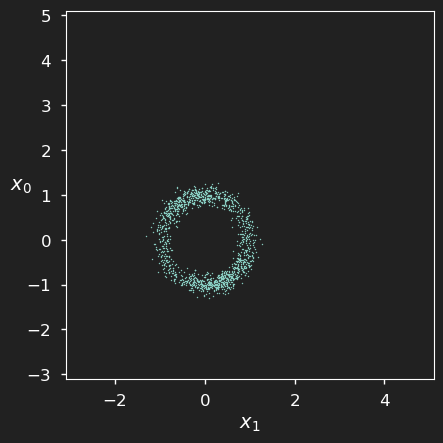

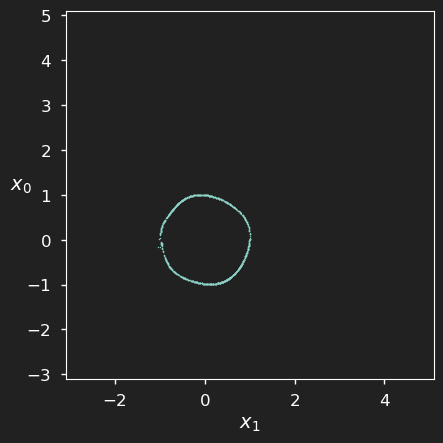

In [47]:
fig = plt.figure(figsize=(10,10))

coord_grid(fig, train_data_np, xylim=[-3.1, 5.1])

plt.show(fig)
plt.close(fig)

fig = plt.figure(figsize=(10,10))

coord_grid(fig, rec_train_data_np, xylim=[-3.1, 5.1])

plt.show(fig)
plt.close(fig)

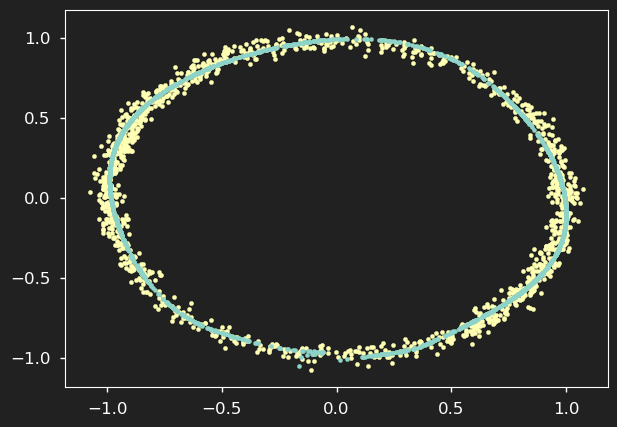

In [48]:
# plt.scatter(*train_data_np.T[:2], c='C0', alpha=.3)
plt.scatter(*slow_proj_np.T[:2], c='C1')
plt.scatter(*rec_train_data_np.T[:2], c='C0')

# plt.ylim([-2,2])
plt.show()

In [49]:
F.mse_loss(slow_proj, rec_train_data)

tensor(0.0037, grad_fn=<MseLossBackward>)

In [50]:
F.l1_loss(slow_proj, rec_train_data)

tensor(0.0317, grad_fn=<L1LossBackward>)

In [51]:
torch.max(torch.abs(slow_proj - rec_train_data))

tensor(1.6357, grad_fn=<MaxBackward1>)

In [52]:
# plt.scatter(*train_data_np.T)
# plt.scatter(*rec_train_data_np.T);

## Encoder accuracy

In [53]:
test_ds = dataset(root / 'data', train=False)
len(test_ds)

660

In [54]:
test_data = test_ds.data
test_data_np = test_data.detach().numpy()
test_data_np.shape

(660, 2)

In [55]:
# plt.scatter(*test_data_np.T, s=3);

In [56]:
dt = train_ds.dt
try:
    sde = train_ds.system.sde
except AttributeError:
    sde = train_ds.system
slow_map = train_ds.system.slow_map

In [57]:
slow_var = slow_map(test_data_np.T)
slow_var.shape

(1, 660)

In [58]:
lat_var = model.encoder(test_ds.data).detach().numpy().T
lat_var.shape

(1, 660)

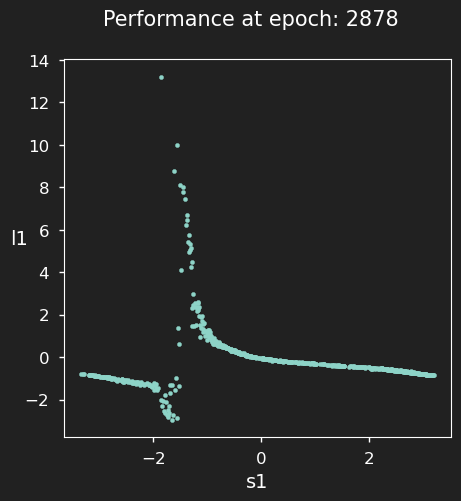

In [59]:
sdim = test_ds.system.sdim
fig, axs = plt.subplots(ncols=sdim, nrows=sdim, figsize=(5*sdim, 5*sdim), sharey='row', sharex='col', squeeze=False)
for m, slow_coord in enumerate(slow_var):
    for n, lat_coord in enumerate(lat_var):
        axs[n,m].scatter(slow_coord, lat_coord)
        if n + 1 == sdim:
            axs[n,m].set_xlabel(f"s{m+1}")
        if m == 0:
            axs[n,m].set_ylabel(f"l{n+1}", rotation=0)
fig.suptitle(f'Performance at epoch: {check_epoch}', size=15)

plt.show()

In [60]:
# fig, axs = plt.subplots(ncols=2, figsize=(9,5), sharey=True)

# train_test_data = [train_ds.data, test_ds.data]
# for ax, data, title in zip(axs, train_test_data, ['Training set', 'Test set']):
#     slow_var = slow_map(data.detach().numpy().T)
#     lat_var = model.encoder(data).detach().numpy()
#     try:
#         ax.scatter(slow_var, lat_var.T)
#     except ValueError:
#         print('Latent layer too large.')
#         plt.close(fig)
    
#     ax.set_title(f'{title}')
#     ax.set_xlabel('slow variable')
# axs[0].set_ylabel('latent variable', labelpad=0)

# fig.tight_layout()

# fig.suptitle(f'Performance at epoch: {check_epoch}', size=15)
# fig.subplots_adjust(top=0.85)
# fig.savefig(root / f"results/figs/{model_id}_slowvar.pdf", dpi=300)
# plt.show(fig)
# plt.close(fig)

## Sample path

In [61]:
# seed setting and solver
seed = 3579
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

# stochastic solver
em = spaths.EulerMaruyama(rng)

tsep = dataset.eps

AttributeError: type object 'Cresc2' has no attribute 'eps'

In [567]:
start = test_data_np[[100]]
tspan = (0, 100*tsep)

test_sol = em.solve(sde, start, tspan, dt)
test_path = test_sol.p[0].T
test_path_t = torch.from_numpy(test_path.T).to(dtype=torch.float)

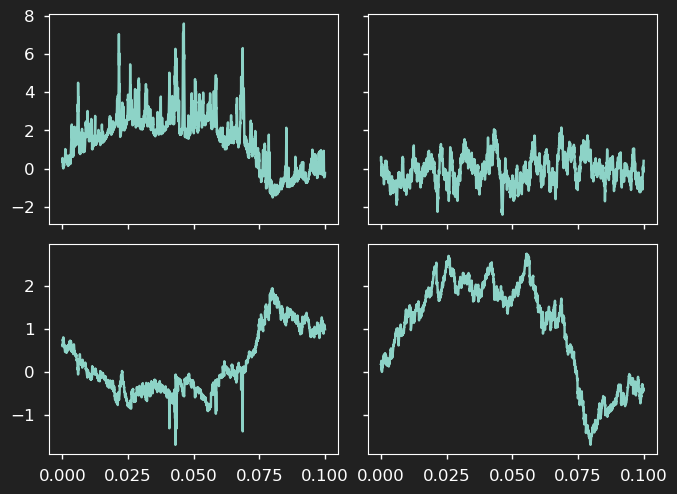

In [568]:
t = np.linspace(*tspan, len(test_path.T))

fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey='row')

axs[0,0].plot(t, test_path[0]);
axs[0,1].plot(t, test_path[1]);


lat_var = model.encoder(test_path_t).detach().numpy()
slow_var = slow_map(test_path).T
axs[1,0].plot(t, lat_var);
axs[1,1].plot(t, slow_var)

fig.tight_layout()
plt.show(fig)

### Slow and fast variablse: variance vs time

In [569]:
idx = 100
nreps = 10_000
tsep = train_ds.eps
ndim = train_ds.system.ndim
dt = train_ds.burst_dt / 4
path_tspan = (0, 1.5*tsep)

In [570]:
dp = rng.permutation(test_data_np)[:100]
ens0 = np.repeat(dp, nreps, axis=0)
ens0.shape

(1000000, 4)

In [571]:
nsteps = int(path_tspan[1] / dt)
bursts = em.burst(sde, ens0, (0, 1), dt).reshape(len(dp), nreps, ndim)
bursts.shape

(100, 10000, 4)

In [572]:
bursts.T.shape

(4, 10000, 100)

In [573]:
rbursts = np.rollaxis(bursts, 2)
rbursts.shape

(4, 100, 10000)

In [574]:
coords_vars = np.var(bursts, axis=1) / dt
coords_vars = coords_vars[:, :5]
print(coords_vars.shape)
slow_vars = np.var(slow_map(bursts.T).T, axis=1) / dt
print(slow_vars.shape)

(100, 4)
(100, 1)


In [575]:
bursts_t = torch.from_numpy(bursts).to(dtype=torch.float)
slow_view = model.encoder(bursts_t).detach().numpy()
slow_view_vars = np.var(slow_view, axis=1) / dt

In [576]:
all_vars = np.hstack([coords_vars, slow_vars, slow_view_vars])
all_vars.shape

(100, 6)

In [577]:
labs_x = [ f'x{n+1}' for n in range(coords_vars.shape[1]) ]
labs_s = [ f'slow{n+1}' for n in range(slow_vars.shape[1]) ]
labs_l = [ f'view{n+1}' for n in range(slow_view_vars.shape[1])]

labels = labs_x + labs_s + labs_l

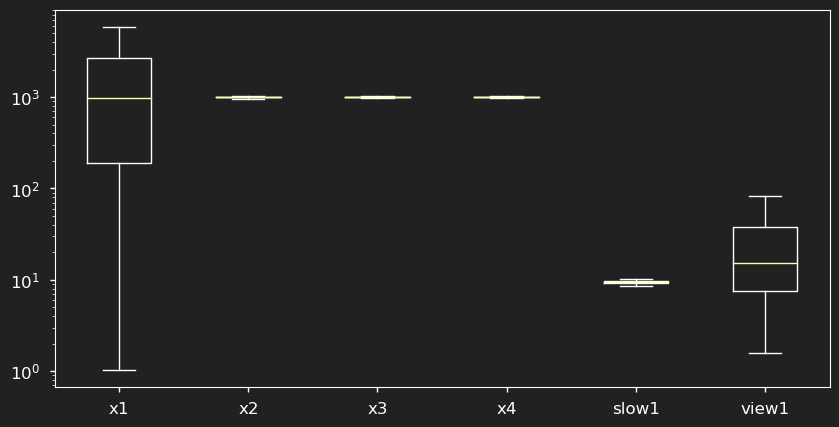

In [582]:
fig, ax = plt.subplots(figsize=(10,5))

ax.boxplot(all_vars, showfliers=False,
            labels=labels);

ax.set_yscale('log')
# plt.boxplot(slow_vars, positions=5);

In [344]:
max_vars = all_vars.max(0)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

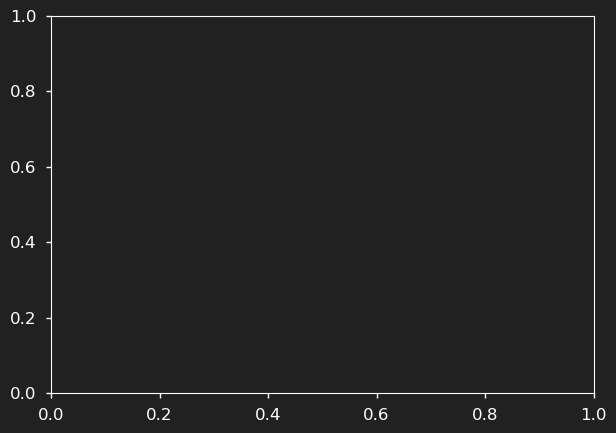

In [345]:
x = range(6)

plt.bar(x, max_vars);
# plt.bar(4, slow_vars)
# plt.bar(5, slow_view_vars)

# plt.yscale('log')
# plt.ylim([10**(-2), 1.0])
# # plt.xticks(x,['x1', 'x2', 'x3', 'x4']);

### Slow and fast variables: variance vs timestep

In [383]:
ndata = 100
nreps = 10_000
dtspan = np.linspace(dt/5, dt, 10)

In [384]:
dp = rng.permutation(test_data_np)[:ndata]
ens0 = np.repeat(dp, nreps, axis=0)
ens0.shape

(1000000, 10)

In [385]:
vars_dt = []
coords_vars_dt = []
slow_vars_dt = []
slow_view_vars_dt = []
for bdt in dtspan:
    bursts = em.burst(sde, ens0, (0, 1), bdt).reshape(len(dp), nreps, ndim)
    
    coords_vars = np.var(bursts, axis=1) / bdt
    coords_vars_dt.append(coords_vars.mean(0))
    
    slow_vars = np.var(slow_map(bursts.T).T, axis=1) / bdt
    slow_vars_dt.append(slow_vars.mean(0))
    
    bursts_t = torch.from_numpy(bursts).to(dtype=torch.float)
    slow_view = model.encoder(bursts_t).detach().numpy()
    slow_view_vars = np.var(slow_view, axis=1)
    slow_view_vars_dt.append(slow_view_vars.mean(0) / bdt)
    
    all_vars = np.hstack([coords_vars, slow_vars, slow_view_vars])
    vars_dt.append(all_vars.mean(0))


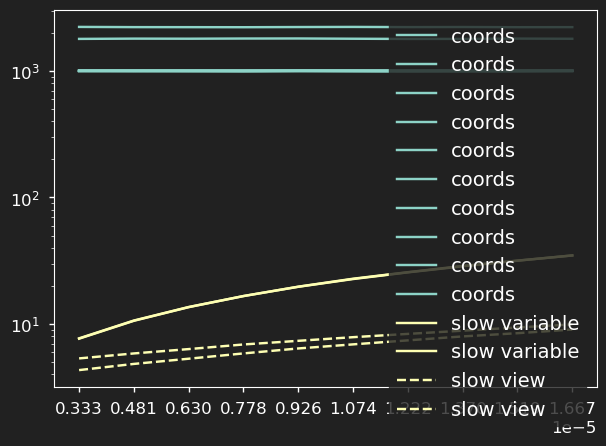

In [386]:
plt.plot(dtspan, coords_vars_dt, c='C0', label='coords');
plt.plot(dtspan, slow_vars_dt, c='C1', label='slow variable')
plt.plot(dtspan, slow_view_vars_dt, '--', c='C1', label='slow view')
plt.legend()
plt.yscale('log')
# plt.ylim([1e-6, 1e-1])
plt.xticks(dtspan);

In [495]:
dp = test_data_np[[100]]
ens0 = np.repeat(dp, nreps, axis=0)
paths_sol = em.solve(sde, ens0, path_tspan, dt)

In [496]:
paths = paths_sol.p
times = paths_sol.t

In [497]:
paths.shape

(10000, 92, 4)

In [498]:
path_vars = np.var(paths, axis=0)

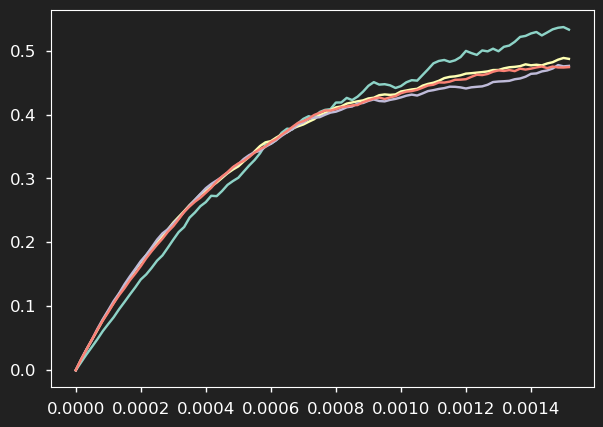

In [499]:
plt.plot(times, path_vars);

In [500]:
slow_path = slow_map(paths.T).T
slow_path.shape

(10000, 92, 1)

In [501]:
slow_vars = np.var(slow_path, axis=0)

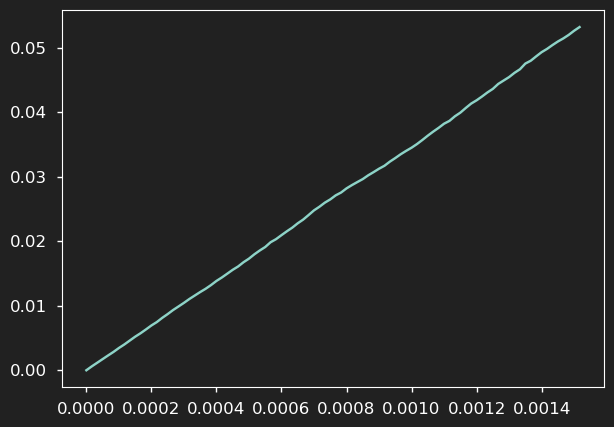

In [502]:
plt.plot(times, slow_vars);

In [503]:
paths_t = torch.from_numpy(paths).to(dtype=torch.float)

slow_view = model.encoder(paths_t).detach().numpy()
slow_view.shape

(10000, 92, 1)

In [504]:
slow_view_vars = np.var(slow_view, axis=0)

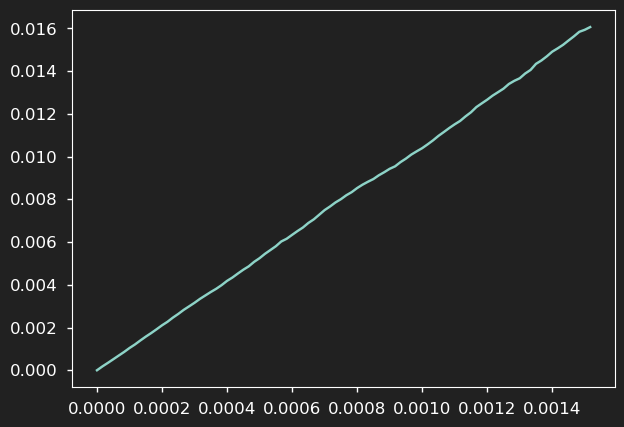

In [505]:
plt.plot(times, slow_view_vars);

In [99]:
train_data = train_ds.data
Y = model(train_data)[1].detach().numpy()
train_data_np= train_data.detach().numpy()
train_means = np.mean(train_data_np, axis=0)
train_stds = np.std(train_data_np, axis=0)

In [100]:
max_deg = 1
powers = [
    (p1, p2)
    for p2 in range(max_deg+1) for p1 in range(max_deg+1)
    if p1 + p2 > 0 and p1 + p2 <= max_deg
]
basis = [
    f"x^{p1}" if p2==0 else (f"y^{p2}" if p1== 0 else f"x^{p1}y^{p2}")
    for p1, p2 in powers
]

x, y = train_data.T
X = np.zeros((len(powers)+1, len(train_data)))
for idx, (n, m) in enumerate(powers):
    X[idx] = x**n * y**m
X[-1] = np.log(x + 3)
basis.append("log(x)")
X = pd.DataFrame(X.T, columns=basis)
X.head()

,x^1,y^1,log(x)
0,-0.961983,-0.236718,0.711978
1,0.818180,0.605251,1.339774
2,-0.268234,0.190552,1.004948
3,1.224008,0.750810,1.440784
4,1.455687,0.988548,1.494181


In [101]:
alpha_list = np.arange(0.001, 0.1, 0.001)
results = dmaps.lasso_adm(X, Y, alpha_list, rng)
results

,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.010,...,0.090,0.091,0.092,0.093,0.094,0.095,0.096,0.097,0.098,0.099
x^1,0.279367,0.308775,0.308220,0.307659,0.307096,0.306533,0.305970,0.305407,0.304844,0.304280,...,0.259243,0.258680,0.258116,0.257553,0.256990,0.256427,0.255863,0.255300,0.254737,0.254173
y^1,0.113922,0.117927,0.117379,0.116837,0.116296,0.115755,0.115215,0.114674,0.114134,0.113593,...,0.070328,0.069787,0.069246,0.068706,0.068165,0.067625,0.067084,0.066544,0.066003,0.065463
log(x),0.088964,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
train_score,0.997929,0.997027,0.996995,0.996949,0.996891,0.996819,0.996735,0.996637,0.996526,0.996403,...,0.944289,0.943110,0.941917,0.940712,0.939494,0.938262,0.937018,0.935761,0.934490,0.933207
test_score,0.997803,0.996724,0.996653,0.996569,0.996472,0.996362,0.996239,0.996104,0.995956,0.995795,...,0.941571,0.940377,0.939169,0.937949,0.936715,0.935470,0.934211,0.932939,0.931655,0.930358


In [102]:
X.describe()

,x^1,y^1,log(x)
count,2.680000e+03,2.680000e+03,2680.000000
mean,1.533547e-07,5.153673e-07,1.030370
std,1.000187e+00,1.000187e+00,0.392422
min,-2.265648e+00,-2.953966e+00,-0.308766
25%,-7.950016e-01,-6.401453e-01,0.790727
50%,1.009066e-01,1.791369e-01,1.131694
75%,8.726342e-01,7.508699e-01,1.353935
max,1.804869e+00,2.201757e+00,1.569630
